# Sweep Explorer - Interactive Parameter Visualization

Interactive explorer for experimental sweep results. Map sweep parameters
(entry_max, label_max, dataset, summarizer, k) onto chart axes, facets,
color, and filters.

**Prerequisites:** Run `scripts/run_experimental_sweep.py` or `pca_kllmeans_sweep.ipynb`
to generate `experimental_sweep_*.pkl` files in the repo root.

In [1]:
# Install hvplot if needed (safe to re-run)
%pip install -q hvplot

import pickle
import warnings
from pathlib import Path

import numpy as np
import pandas as pd

import hvplot.pandas  # registers .hvplot accessor on DataFrames
import panel as pn

# Enable Panel widgets in notebook
pn.extension('tabulator', design='material', sizing_mode='stretch_width')

warnings.filterwarnings('ignore', category=FutureWarning)

Note: you may need to restart the kernel to use updated packages.


C:\Users\spenc\AppData\Local\Temp\ipykernel_28392\3419695285.py:15: UserWarning: Using Panel interactively in VSCode notebooks requires the jupyter_bokeh package to be installed. You can install it with:

   pip install jupyter_bokeh

or:
    conda install jupyter_bokeh

and try again.
  pn.extension('tabulator', design='material', sizing_mode='stretch_width')


In [2]:
def load_sweep_dataframe(data_dir: str = "../experimental_results") -> pd.DataFrame:
    """
    Load all experimental_sweep_*.pkl files and flatten into one row per (file, k).

    Args:
        data_dir: Directory containing pickle files (default: ../experimental_results)

    Returns:
        DataFrame with sweep parameters and metrics as columns.
    """
    rows = []
    errors = []

    def record_error(file_name: str, message: str) -> None:
        errors.append((file_name, message))

    data_path = Path(data_dir)
    if not data_path.exists():
        print(f"[WARN] Data directory not found: {data_path.resolve()}")
        return pd.DataFrame()

    for pkl_path in sorted(data_path.glob("experimental_sweep_*.pkl")):
        try:
            if pkl_path.stat().st_size == 0:
                record_error(pkl_path.name, "empty file")
                continue
        except OSError as e:
            record_error(pkl_path.name, f"stat failed: {type(e).__name__}: {e}")
            continue

        try:
            with open(pkl_path, "rb") as f:
                data = pickle.load(f)
        except Exception as e:
            record_error(pkl_path.name, f"pickle load failed: {type(e).__name__}: {e}")
            continue

        if not isinstance(data, dict):
            record_error(pkl_path.name, f"unexpected payload type: {type(data).__name__}")
            continue

        meta = data.get("metadata") or {}
        if not isinstance(meta, dict):
            meta = {}

        result = data.get("result") or {}
        if not isinstance(result, dict):
            record_error(pkl_path.name, "missing result dict")
            continue

        by_k = result.get("by_k") or {}
        if isinstance(by_k, list):
            converted = {}
            for item in by_k:
                if isinstance(item, dict) and "k" in item:
                    converted[str(item["k"])] = item
            by_k = converted

        if not isinstance(by_k, dict) or not by_k:
            record_error(pkl_path.name, "missing by_k data")
            continue

        def metric_from(stab_dict, key, stat):
            if not isinstance(stab_dict, dict):
                return None
            nested = stab_dict.get(key)
            if isinstance(nested, dict) and stat in nested:
                return nested.get(stat)
            flat_key = f"{key}_{stat}"
            return stab_dict.get(flat_key)

        dataset = (
            meta.get("benchmark_source")
            or meta.get("dataset")
            or data.get("dataset_name")
            or data.get("dataset")
            or "unknown"
        )
        summarizer = meta.get("summarizer") or meta.get("summarizer_name") or "unknown"
        entry_max = meta.get("entry_max", data.get("entry_max"))
        label_max = meta.get("label_max", data.get("label_max"))
        actual_entry_count = meta.get("actual_entry_count", data.get("actual_entry_count"))
        actual_label_count = meta.get("actual_label_count", data.get("actual_label_count"))

        for k_str, k_data in by_k.items():
            try:
                k_val = int(k_str)
            except Exception:
                record_error(pkl_path.name, f"invalid k value: {k_str!r}")
                continue

            if not isinstance(k_data, dict):
                record_error(
                    pkl_path.name,
                    f"invalid k payload for k={k_str}: {type(k_data).__name__}",
                )
                continue

            stab = k_data.get("stability") or {}

            # Handle StabilityMetrics dataclass instances vs plain dicts
            if hasattr(stab, "__dict__") and not isinstance(stab, dict):
                stab = stab.__dict__

            if not isinstance(stab, dict):
                stab = {}

            inertia_mean = metric_from(stab, "dispersion", "mean")
            if inertia_mean is None:
                inertia_mean = metric_from(stab, "inertia", "mean")

            inertia_std = metric_from(stab, "dispersion", "std")
            if inertia_std is None:
                inertia_std = metric_from(stab, "inertia", "std")

            rows.append({
                "entry_max": entry_max,
                "dataset": dataset,
                "label_max": label_max,
                "summarizer": summarizer,
                "k": k_val,
                "ari_mean": metric_from(stab, "stability_ari", "mean"),
                "ari_std": metric_from(stab, "stability_ari", "std"),
                "silhouette_mean": metric_from(stab, "silhouette", "mean"),
                "silhouette_std": metric_from(stab, "silhouette", "std"),
                "coverage_mean": metric_from(stab, "coverage", "mean"),
                "coverage_std": metric_from(stab, "coverage", "std"),
                "inertia_mean": inertia_mean,
                "inertia_std": inertia_std,
                "ari_vs_ground_truth": stab.get("ari_vs_ground_truth"),
                "objective": k_data.get("objective"),
                "actual_entry_count": actual_entry_count,
                "actual_label_count": actual_label_count,
                "source_file": pkl_path.name,
            })

    if errors:
        print(f"[WARN] Failed to load/parse {len(errors)} file(s):")
        for name, err in errors[:8]:
            print(f"  {name}: {err}")
        if len(errors) > 8:
            print(f"  ... {len(errors) - 8} more")

    df = pd.DataFrame(rows)

    # Convert None to NaN for numeric columns (fixes hvplot/numpy comparison errors)
    if not df.empty:
        metric_cols = [
            "ari_mean",
            "ari_std",
            "silhouette_mean",
            "silhouette_std",
            "coverage_mean",
            "coverage_std",
            "inertia_mean",
            "inertia_std",
            "ari_vs_ground_truth",
            "objective",
        ]
        numeric_cols = metric_cols + [
            "actual_entry_count",
            "actual_label_count",
            "entry_max",
            "label_max",
            "k",
        ]
        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors="coerce")

        # Drop metric columns that are completely empty
        empty_metrics = [
            col for col in metric_cols if col in df.columns and df[col].isna().all()
        ]
        if empty_metrics:
            df = df.drop(columns=empty_metrics)

        def safe_unique(col):
            if col not in df.columns:
                return []
            return sorted(df[col].dropna().unique(), key=str)

        source_count = df["source_file"].nunique() if "source_file" in df.columns else 0
        print(f"[OK] Loaded {len(df)} rows from {source_count} pickle files.")
        if "dataset" in df.columns:
            print(f"     Datasets: {safe_unique('dataset')}")
        if "summarizer" in df.columns:
            print(f"     Summarizers: {safe_unique('summarizer')}")
        if "entry_max" in df.columns:
            print(f"     entry_max: {safe_unique('entry_max')}")
        if "label_max" in df.columns:
            print(f"     label_max: {safe_unique('label_max')}")
        if "k" in df.columns and df["k"].notna().any():
            print(f"     k range: {df['k'].min()} - {df['k'].max()}")
        available_metrics = [
            c for c in df.columns if c in metric_cols and df[c].notna().any()
        ]
        print(f"     Available metric columns: {available_metrics}")
        print(f"     DataFrame shape: {df.shape}")
    else:
        print("[WARN] No valid sweep data loaded. Run sweep script first or check data_dir.")
    return df


df = load_sweep_dataframe()

# FILTER: Only include custom sweep data (label_max 10 and 14)
if not df.empty:
    pre_filter_len = len(df)
    df = df[df['label_max'].isin([10, 14])].copy()
    post_filter_len = len(df)
    print(f"[INFO] Filtered for label_max in [10, 14]: {pre_filter_len} → {post_filter_len} rows (removed {pre_filter_len - post_filter_len} rows)")


# Deduplicate: keep only latest run per (dataset, summarizer, entry_max, label_max, k)
if not df.empty:
    dedupe_cols = ["dataset", "summarizer", "entry_max", "label_max", "k"]
    pre_dedupe_len = len(df)
    df = df.sort_values("source_file").drop_duplicates(subset=dedupe_cols, keep="last")
    post_dedupe_len = len(df)
    
    if pre_dedupe_len > post_dedupe_len:
        print(f"[INFO] De-duplicated: {pre_dedupe_len} → {post_dedupe_len} rows (removed {pre_dedupe_len - post_dedupe_len} duplicates)")
    
    # Validation: check max group size
    max_group_size = df.groupby(dedupe_cols).size().max()
    if max_group_size > 1:
        print(f"[WARN] Still have duplicates! Max group size: {max_group_size}")
    else:
        print(f"[OK] Deduplication validated: max group size = {max_group_size}")

print(f"\n[DEBUG] df.empty = {df.empty}")
print(f"[DEBUG] len(df) = {len(df)}")
df.head()

[OK] Loaded 4995 rows from 555 pickle files.
     Datasets: ['20newsgroups_10cat', '20newsgroups_6cat', 'dbpedia', 'news_category', 'yahoo_answers']
     Summarizers: ['None', 'gpt-4o', 'gpt-4o-mini', 'gpt-5-chat']
     entry_max: [np.int64(100), np.int64(200), np.int64(300), np.int64(400)]
     label_max: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
     k range: 2 - 10
     Available metric columns: ['ari_mean', 'ari_std', 'silhouette_mean', 'silhouette_std', 'coverage_mean', 'coverage_std', 'inertia_mean', 'inertia_std', 'objective']
     DataFrame shape: (4995, 17)
[INFO] De-duplicated: 4995 → 3204 rows (removed 1791 duplicates)
[OK] Deduplication validated: max group size = 1

[DEBUG] df.empty = False
[DEBUG] len(df) = 3204


,entry_max,dataset,label_max,summarizer,k,ari_mean,ari_std,silhouette_mean,silhouette_std,coverage_mean,coverage_std,inertia_mean,inertia_std,objective,actual_entry_count,actual_label_count,source_file
44,100,20newsgroups_10cat,1,None,10,0.181639,0.051789,0.043777,0.009698,0.0040,0.004899,0.558571,0.010050,53.535692,100,1,experimental_sweep_entry100_20newsgroups_10cat...
43,100,20newsgroups_10cat,1,None,9,0.184756,0.050578,0.045866,0.010594,0.0045,0.005895,0.574034,0.011288,55.757970,100,1,experimental_sweep_entry100_20newsgroups_10cat...
42,100,20newsgroups_10cat,1,None,8,0.186675,0.052183,0.045949,0.010918,0.0025,0.005362,0.592770,0.011140,57.416618,100,1,experimental_sweep_entry100_20newsgroups_10cat...
41,100,20newsgroups_10cat,1,None,7,0.196570,0.055731,0.047883,0.008602,0.0020,0.004000,0.610262,0.010865,58.906744,100,1,experimental_sweep_entry100_20newsgroups_10cat...
40,100,20newsgroups_10cat,1,None,6,0.187128,0.062079,0.048251,0.008783,0.0010,0.003000,0.633290,0.010587,62.162052,100,1,experimental_sweep_entry100_20newsgroups_10cat...


## Data Filtering

Select specific parameter combinations to analyze:

In [3]:
if not df.empty:
    # Create filter widgets
    datasets = sorted(df['dataset'].unique())
    summarizers = sorted(df['summarizer'].unique())
    entry_maxes = sorted(df['entry_max'].dropna().unique())
    label_maxes = sorted(df['label_max'].dropna().unique())
    
    dataset_filter = pn.widgets.MultiChoice(
        name='Datasets', 
        options=datasets, 
        value=datasets[:3] if len(datasets) > 3 else datasets,
        solid=False
    )
    summarizer_filter = pn.widgets.MultiChoice(
        name='Summarizers', 
        options=summarizers, 
        value=summarizers,
        solid=False
    )
    entry_max_filter = pn.widgets.MultiChoice(
        name='Entry Max', 
        options=[int(x) for x in entry_maxes],
        value=[int(x) for x in entry_maxes[:2]] if len(entry_maxes) > 2 else [int(x) for x in entry_maxes],
        solid=False
    )
    label_max_filter = pn.widgets.MultiChoice(
        name='Label Max', 
        options=[int(x) for x in label_maxes],
        value=[int(x) for x in label_maxes[:3]] if len(label_maxes) > 3 else [int(x) for x in label_maxes],
        solid=False
    )
    
    # Function to apply filters
    @pn.depends(dataset_filter, summarizer_filter, entry_max_filter, label_max_filter)
    def get_filtered_df(datasets, summarizers, entry_maxes, label_maxes):
        filtered = df.copy()
        if datasets:
            filtered = filtered[filtered['dataset'].isin(datasets)]
        if summarizers:
            filtered = filtered[filtered['summarizer'].isin(summarizers)]
        if entry_maxes:
            filtered = filtered[filtered['entry_max'].isin(entry_maxes)]
        if label_maxes:
            filtered = filtered[filtered['label_max'].isin(label_maxes)]
        
        print(f"Filtered to {len(filtered)} rows (from {len(df)} total)")
        return filtered
    
    # Display filter controls
    filter_panel = pn.Column(
        "### Filter Data",
        pn.Row(dataset_filter, summarizer_filter),
        pn.Row(entry_max_filter, label_max_filter),
        pn.pane.Markdown("**Note:** Select values above, then run cells below to see filtered results."),
    )
    filter_panel
else:
    print("[WARN] No data to filter")

In [4]:
# Apply filters to create filtered dataframe
if not df.empty:
    df_filtered = get_filtered_df(
        dataset_filter.value,
        summarizer_filter.value, 
        entry_max_filter.value,
        label_max_filter.value
    )
    
    print(f"\nFiltered data summary:")
    print(f"  Datasets: {sorted(df_filtered['dataset'].unique())}")
    print(f"  Summarizers: {sorted(df_filtered['summarizer'].unique())}")
    print(f"  Entry max: {sorted(df_filtered['entry_max'].dropna().unique())}")
    print(f"  Label max: {sorted(df_filtered['label_max'].dropna().unique())}")
    print(f"  K range: {df_filtered['k'].min()} - {df_filtered['k'].max()}")
else:
    df_filtered = df

Filtered to 486 rows (from 3204 total)

Filtered data summary:
  Datasets: ['20newsgroups_10cat', '20newsgroups_6cat', 'dbpedia']
  Summarizers: ['None', 'gpt-4o-mini', 'gpt-5-chat']
  Entry max: [np.int64(100), np.int64(200)]
  Label max: [np.int64(1), np.int64(2), np.int64(3)]
  K range: 2 - 10


## Interactive Explorer

The explorer below lets you change:
- **Kind**: Chart type (line, scatter, bar, box, etc.)
- **X / Y**: Which column on each axis
- **by**: Color grouping
- **groupby**: Creates a widget (slider/dropdown) to step through values
- Additional options in the sidebar (aggregation, faceting, etc.)

If `hvDataFrameExplorer` is not available in your hvplot version, Cell 5 provides
a manual widget-based fallback.

In [5]:
# Try the built-in explorer first - using FILTERED data
try:
    from hvplot.ui import hvDataFrameExplorer
except ImportError:
    try:
        from hvplot.explorer import hvDataFrameExplorer
    except ImportError:
        hvDataFrameExplorer = None

print(f"[DEBUG] hvDataFrameExplorer available: {hvDataFrameExplorer is not None}")
print(f"[DEBUG] df_filtered.empty: {df_filtered.empty}")

if hvDataFrameExplorer is not None and not df_filtered.empty:
    # Find first metric column (exclude experimental parameters)
    numeric_cols = df_filtered.select_dtypes(include=['number']).columns
    # Prioritize actual metrics over experimental parameters
    metric_priority = ['ari_mean', 'silhouette_mean', 'coverage_mean', 'inertia_mean']
    metadata_cols = ['k', 'entry_max', 'label_max', 'actual_entry_count', 'actual_label_count']
    
    available_metrics = [col for col in numeric_cols if df_filtered[col].notna().any() and col not in metadata_cols]
    
    # Try to use a priority metric first
    default_y = None
    for metric in metric_priority:
        if metric in available_metrics:
            default_y = metric
            break
    
    # Fall back to first available if no priority metric found
    if default_y is None and available_metrics:
        default_y = available_metrics[0]
    
    if default_y:
        print(f"[INFO] Using '{default_y}' as default y-axis. Available metrics: {available_metrics}")
        print(f"[DEBUG] Creating explorer with {len(df_filtered)} rows...")
        
        try:
            explorer = hvDataFrameExplorer(
                df_filtered,
                kind="line",
                x="k",
                y=default_y,
                by=["summarizer"],
            )
            print(f"[DEBUG] Explorer created successfully: {type(explorer)}")
            print(f"[DEBUG] Displaying explorer...")
            display(explorer)  # Explicit display
        except Exception as e:
            print(f"[ERROR] Failed to create/display explorer: {e}")
            import traceback
            traceback.print_exc()
    else:
        print("[WARN] No metric columns with data available for plotting")
else:
    if df_filtered.empty:
        print("[WARN] No data after filtering. Adjust filters above.")
    else:
        print("[INFO] hvDataFrameExplorer not available. Use the manual explorer in the next cell.")

[DEBUG] hvDataFrameExplorer available: True
[DEBUG] df_filtered.empty: False
[INFO] Using 'ari_mean' as default y-axis. Available metrics: ['ari_mean', 'ari_std', 'silhouette_mean', 'silhouette_std', 'coverage_mean', 'coverage_std', 'inertia_mean', 'inertia_std', 'objective']
[DEBUG] Creating explorer with 486 rows...
[DEBUG] Explorer created successfully: <class 'hvplot.ui.hvDataFrameExplorer'>
[DEBUG] Displaying explorer...


ModuleNotFoundError: No module named 'jupyter_bokeh'

hvDataFrameExplorer(advanced=Advanced(explorer=..., name='Advanced00302', opts={}), axes=Axes(explorer=..., height=None, legend='bottom_right', logx=False, logy=False, name='Axes00296', responsive=True, shared_axes=True, width=None, xlim=None, ylim=None), by=['summarizer'], code="df.hvplot(\n    by=['summarizer'],\n    kind='line',\n    x='k',\n    y=['ari_mean'],\n    legend='bottom_right',\n    widget_location='bottom',\n)", colormapping=Colormapping(clim=None, cmap='kbc_r', cnorm='linear', color=None, colorbar=None, explorer=..., name='Colormapping00297', rescale_discrete_levels=True, symmetric=False), geographic=Geographic(crs=None, crs_kwargs={}, explorer=..., feature_scale='110m', features=None, geo=False, global_extent=None, name='Geographic00299', project=False, projection=None, projection_kwargs={}, tiles=None), groupby=[], kind='line', labels=Labels(clabel='', explorer=..., fontscale=1, name='Labels00298', rot=0, title='', xlabel='', ylabel=''), name='hvDataFrameExplorer00274

In [6]:
# Manual explorer: Panel widgets + hvplot (works in any hvplot version)
# Run this cell if hvDataFrameExplorer is not available, or if you want more control.

if df.empty:
    print("[WARN] No data loaded.")
else:
    numeric_cols = list(df.select_dtypes(include="number").columns)
    categorical_cols = [c for c in df.columns if c not in numeric_cols]
    all_cols = numeric_cols + categorical_cols

    # --- Chart controls ---
    kind_select = pn.widgets.Select(name="Chart Type", options=["line", "scatter", "bar", "box", "area", "hist"], value="line", width=140)
    x_select = pn.widgets.Select(name="X Axis", options=numeric_cols, value="k", width=180)
    y_select = pn.widgets.Select(name="Y Axis", options=numeric_cols, value="ari_mean", width=180)
    by_select = pn.widgets.Select(name="Color (by)", options=["None"] + all_cols, value="summarizer", width=180)
    facet_col = pn.widgets.Select(name="Facet Column", options=["None"] + categorical_cols, value="None", width=180)
    facet_row = pn.widgets.Select(name="Facet Row", options=["None"] + categorical_cols, value="None", width=180)

    # --- Filter widgets for sweep parameters ---
    filter_widgets = {}
    for col in ["entry_max", "label_max", "dataset", "summarizer"]:
        if col in df.columns:
            unique_vals = sorted(df[col].dropna().unique(), key=str)
            if len(unique_vals) <= 30:
                filter_widgets[col] = pn.widgets.MultiChoice(
                    name=f"Filter: {col}",
                    options=[str(v) for v in unique_vals],
                    value=[str(v) for v in unique_vals],
                    width=300,
                )

    plot_pane = pn.pane.HoloViews(None, sizing_mode="stretch_width", min_height=450)

    def update_plot(*events):
        filtered = df.copy()

        # Apply filters
        for col, widget in filter_widgets.items():
            if widget.value:
                filtered = filtered[filtered[col].astype(str).isin(widget.value)]

        if filtered.empty:
            plot_pane.object = None
            return

        kwargs = {
            "kind": kind_select.value,
            "x": x_select.value,
            "y": y_select.value,
            "responsive": True,
            "height": 400,
        }
        if by_select.value != "None":
            kwargs["by"] = by_select.value
        if facet_col.value != "None":
            kwargs["col"] = facet_col.value
        if facet_row.value != "None":
            kwargs["row"] = facet_row.value

        try:
            plot = filtered.hvplot(**kwargs)
            plot_pane.object = plot
        except Exception as e:
            print(f"Plot error: {e}")
            plot_pane.object = None

    # Wire widgets
    for w in [kind_select, x_select, y_select, by_select, facet_col, facet_row]:
        w.param.watch(update_plot, "value")
    for w in filter_widgets.values():
        w.param.watch(update_plot, "value")

    # Initial plot
    update_plot()

    # Layout
    controls = pn.Column(
        pn.pane.Markdown("### Chart Controls"),
        pn.Row(kind_select, x_select, y_select, by_select),
        pn.Row(facet_col, facet_row),
        pn.pane.Markdown("### Filters"),
        *list(filter_widgets.values()),
    )

    pn.Column(controls, plot_pane)

## Simple Plot Test

Basic hvplot to verify plotting works:

In [7]:
# Simple test plot - using FILTERED data
if not df_filtered.empty and 'ari_mean' in df_filtered.columns:
    print(f"[DEBUG] Creating simple line plot with {len(df_filtered)} rows...")
    try:
        plot = df_filtered.hvplot.line(x='k', y='ari_mean', by='summarizer', width=800, height=400, 
                                       title="ARI Mean vs K (Filtered Data)")
        print(f"[DEBUG] Plot created: {type(plot)}")
        display(plot)
    except Exception as e:
        print(f"[ERROR] Simple plot failed: {e}")
        import traceback
        traceback.print_exc()
else:
    print(f"[WARN] Cannot create plot. df_filtered.empty={df_filtered.empty}, has ari_mean={'ari_mean' in df_filtered.columns if not df_filtered.empty else 'N/A'}")

[DEBUG] Creating simple line plot with 486 rows...
[DEBUG] Plot created: <class 'holoviews.core.overlay.NdOverlay'>


:NdOverlay   [summarizer]
   :Curve   [k]   (ari_mean)

## Quick Preset Plots

The cells below provide one-liner hvplot calls for common views.
Modify them as needed.

In [8]:
if not df.empty:
    # Check which metrics are available
    numeric_cols = df.select_dtypes(include=['number']).columns
    available_metrics = [col for col in numeric_cols if df[col].notna().any() and col != 'k']
    
    if 'ari_mean' in df.columns and df['ari_mean'].notna().any():
        y_col = 'ari_mean'
        title = "ARI vs K"
    elif available_metrics:
        y_col = available_metrics[0]
        title = f"{y_col} vs K"
    else:
        print("[WARN] No numeric columns available for plotting")
        y_col = None
    
    if y_col:
        df.hvplot.line(
            x="k", y=y_col, by="summarizer",
            groupby=["dataset", "entry_max", "label_max"],
            title=title,
            height=400, responsive=True,
        )
else:
    print("[WARN] No data to plot")

In [9]:
if not df.empty:
    df.hvplot.heatmap(
        x="k", y="label_max", C="silhouette_mean",
        groupby=["dataset", "summarizer", "entry_max"],
        cmap="viridis", title="Silhouette Mean",
        height=400, responsive=True,
    )

In [10]:
if not df.empty:
    # Check which metrics are available
    numeric_cols = df.select_dtypes(include=['number']).columns
    available_metrics = [col for col in numeric_cols if df[col].notna().any() and col != 'k']
    
    if 'ari_mean' in df.columns and df['ari_mean'].notna().any():
        y_col = 'ari_mean'
        title = "ARI Distribution by Dataset"
    elif available_metrics:
        y_col = available_metrics[0]
        title = f"{y_col} Distribution by Dataset"
    else:
        print("[WARN] No numeric columns available for plotting")
        y_col = None
    
    if y_col:
        df.hvplot.box(
            y=y_col, by="dataset",
            groupby=["entry_max", "label_max"],
            title=title,
            height=400, responsive=True,
        )
else:
    print("[WARN] No data to plot")

## Subplot Grid: Metric vs K across Label Max and Summarizers

Matplotlib subplot grid where:
- **Pre-filter**: Select entry_max, dataset, and metric
- **Rows**: Summarizers
- **Columns**: Label max values
- **Each subplot**: K (x-axis) vs metric value (y-axis)

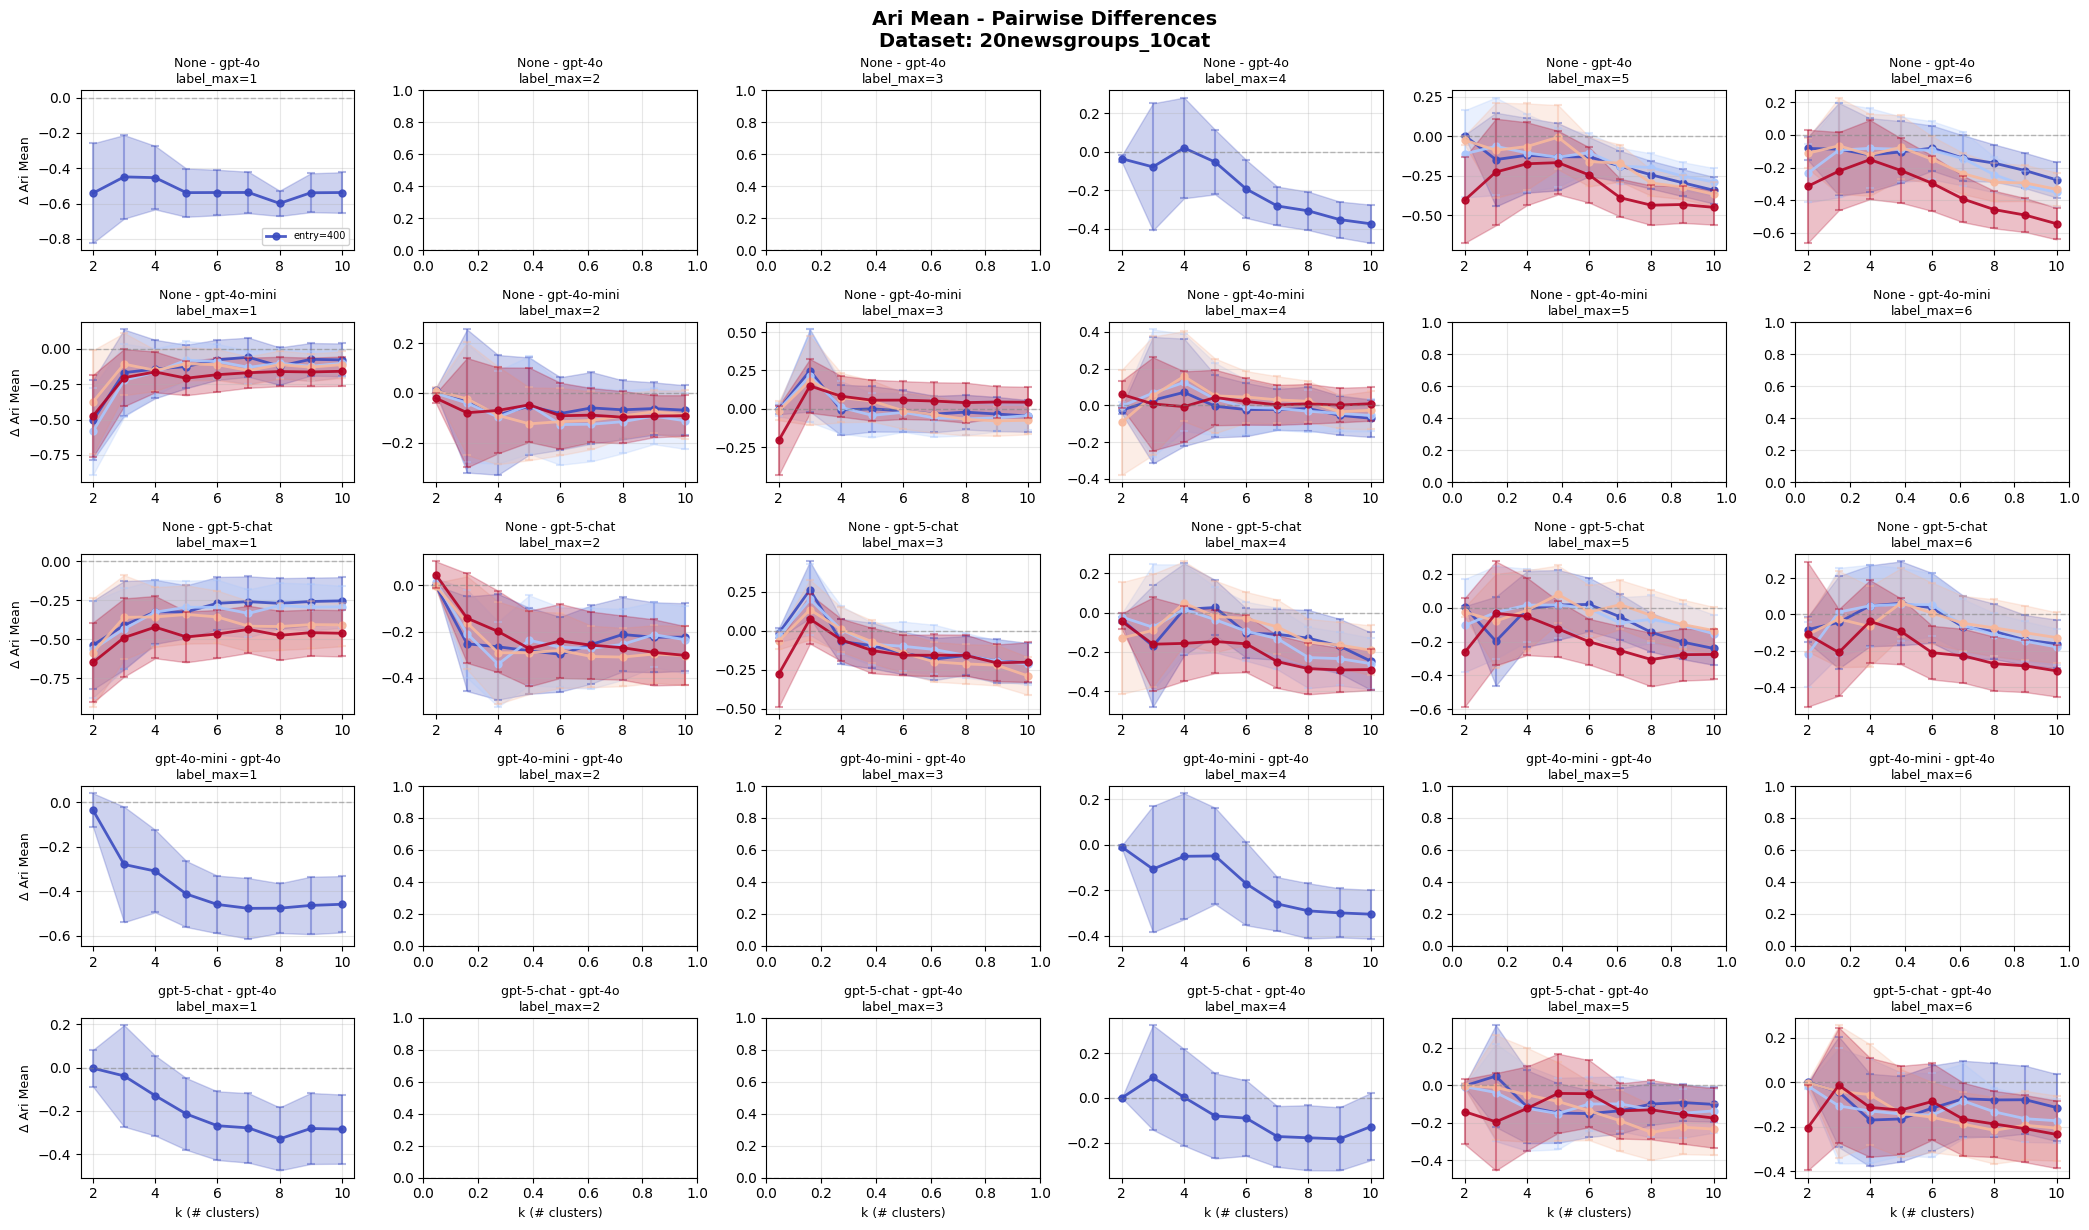

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

if not df.empty:
    # Get available options
    datasets_avail = sorted(df['dataset'].unique())
    
    # Metric options (actual clustering metrics)
    metric_options = {
        'ARI Mean': 'ari_mean',
        'Silhouette Mean': 'silhouette_mean',
        'Coverage Mean': 'coverage_mean',
        'Inertia Mean': 'inertia_mean',
        'ARI vs Ground Truth': 'ari_vs_ground_truth',
        'Objective': 'objective'
    }
    
    # Create selection widgets
    dataset_select = pn.widgets.Select(
        name='Dataset',
        options=datasets_avail,
        value=datasets_avail[0] if datasets_avail else None
    )
    
    metric_select = pn.widgets.Select(
        name='Metric',
        options=metric_options,
        value='ari_mean'
    )
    
    # Define pairwise comparisons
    comparisons = [
        ('None', 'gpt-4o', 'None - gpt-4o'),
        ('None', 'gpt-4o-mini', 'None - gpt-4o-mini'),
        ('None', 'gpt-5-chat', 'None - gpt-5-chat'),
        ('gpt-4o-mini', 'gpt-4o', 'gpt-4o-mini - gpt-4o'),
        ('gpt-5-chat', 'gpt-4o', 'gpt-5-chat - gpt-4o'),
    ]
    
    # Function to create the subplot grid
    @pn.depends(dataset_select, metric_select)
    def create_subplot_grid(dataset, metric):
        if dataset is None:
            return pn.pane.Markdown("**Please select dataset**")
        
        # Filter data by dataset only
        df_filtered = df[df['dataset'] == dataset]
        
        if df_filtered.empty:
            return pn.pane.Markdown(f"**No data for dataset={dataset}**")
        
        # Check if metric has data
        if metric not in df_filtered.columns or df_filtered[metric].isna().all():
            return pn.pane.Markdown(f"**Metric '{metric}' has no data for this selection**")
        
        # Get unique values for dimensions
        label_maxes = sorted(df_filtered['label_max'].dropna().unique())
        entry_maxes = sorted(df_filtered['entry_max'].dropna().unique(), reverse=True)
        
        if not label_maxes or not entry_maxes:
            return pn.pane.Markdown("**No data available for plotting**")
        
        # Create color map: blue (high entry_max) → red (low entry_max)
        colors = cm.coolwarm(np.linspace(0, 1, len(entry_maxes)))
        
        # Create subplot grid - rows are now comparisons
        n_rows = len(comparisons)
        n_cols = len(label_maxes)
        
        fig, axes = plt.subplots(
            nrows=n_rows,
            ncols=n_cols,
            figsize=(n_cols * 3.5, n_rows * 2.5),
            squeeze=False
        )
        
        fig.suptitle(f'{metric.replace("_", " ").title()} - Pairwise Differences\nDataset: {dataset}', 
                     fontsize=14, fontweight='bold')
        
        std_col = metric.replace('_mean', '_std')
        has_std = std_col in df_filtered.columns and std_col != metric
        
        # Plot each comparison
        for i, (summ_a, summ_b, label) in enumerate(comparisons):
            for j, label_max in enumerate(label_maxes):
                ax = axes[i, j]
                
                # Plot a line for each entry_max
                for idx, entry_max in enumerate(entry_maxes):
                    # Get data for both summarizers
                    data_a = df_filtered[
                        (df_filtered['summarizer'] == summ_a) &
                        (df_filtered['label_max'] == label_max) &
                        (df_filtered['entry_max'] == entry_max)
                    ].sort_values('k')
                    
                    data_b = df_filtered[
                        (df_filtered['summarizer'] == summ_b) &
                        (df_filtered['label_max'] == label_max) &
                        (df_filtered['entry_max'] == entry_max)
                    ].sort_values('k')
                    
                    # Merge on k to compute differences
                    if not data_a.empty and not data_b.empty:
                        left_cols = ['k', metric] + ([std_col] if has_std else [])
                        merged = data_a[left_cols].merge(
                            data_b[left_cols], 
                            on='k', 
                            suffixes=('_a', '_b')
                        )
                        
                        if not merged.empty:
                            # Compute difference: A - B
                            metric_a = merged[f'{metric}_a']
                            metric_b = merged[f'{metric}_b']
                            if getattr(metric_a, "ndim", 1) != 1:
                                metric_a = metric_a.iloc[:, 0]
                            if getattr(metric_b, "ndim", 1) != 1:
                                metric_b = metric_b.iloc[:, 0]
                            merged['diff'] = metric_a - metric_b
                            
                            # Error propagation: σ_diff = sqrt(σ_a² + σ_b²)
                            if has_std:
                                std_a = merged[f'{std_col}_a']
                                std_b = merged[f'{std_col}_b']
                                if getattr(std_a, "ndim", 1) != 1:
                                    std_a = std_a.iloc[:, 0]
                                if getattr(std_b, "ndim", 1) != 1:
                                    std_b = std_b.iloc[:, 0]
                                if not std_a.isna().all() and not std_b.isna().all():
                                    merged['diff_std'] = np.sqrt(std_a**2 + std_b**2)
                                else:
                                    merged['diff_std'] = np.nan
                            else:
                                merged['diff_std'] = np.nan
                            
                            color = colors[idx]
                            
                            # Plot line
                            ax.plot(merged['k'], merged['diff'], 
                                   marker='o', linewidth=2, markersize=5,
                                   color=color, label=f'entry={int(entry_max)}',
                                   alpha=0.9)
                            
                            # Add error bars if available
                            if has_std and not merged['diff_std'].isna().all():
                                # Shaded region
                                ax.fill_between(
                                    merged['k'],
                                    merged['diff'] - merged['diff_std'],
                                    merged['diff'] + merged['diff_std'],
                                    color=color,
                                    alpha=0.25
                                )
                                
                                # Error bars on points
                                ax.errorbar(merged['k'], merged['diff'], 
                                           yerr=merged['diff_std'],
                                           fmt='none', ecolor=color, 
                                           alpha=0.4, capsize=3, capthick=1.5)
                
                # Add horizontal line at y=0
                ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
                
                # Styling
                ax.set_title(f"{label}\nlabel_max={int(label_max)}", fontsize=9)
                ax.grid(True, alpha=0.3)
                
                # Legend on first subplot only
                if i == 0 and j == 0:
                    ax.legend(fontsize=7, loc='best', framealpha=0.9)
                
                # Labels only on edges
                if j == 0:
                    ax.set_ylabel(f'Δ {metric.replace("_", " ").title()}', fontsize=9)
                if i == n_rows - 1:
                    ax.set_xlabel('k (# clusters)', fontsize=9)
        
        plt.tight_layout()
        return pn.pane.Matplotlib(fig, dpi=100)
    
    # Layout
    controls = pn.Column(
        "### Controls",
        pn.Row(dataset_select, metric_select),
        pn.pane.Markdown("**Note:** Each line represents a different entry_max value (blue=high, red=low)."),
        pn.pane.Markdown("**Rows show pairwise differences** between summarizers (positive = first is better)."),
        pn.pane.Markdown("**Error bars** computed via error propagation: σ_diff = √(σ_a² + σ_b²)")
    )
    
    pn.Column(controls, create_subplot_grid).servable()
else:
    print("[WARN] No data available")

## Batch Generate All Subplot Grids

Generate and save subplot grid images for all metric × dataset combinations:

In [12]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from pathlib import Path

if not df.empty:
    # Create output directory
    output_dir = Path("..") / "experimental_results" / "plots"
    output_dir.mkdir(exist_ok=True, parents=True)
    
    print(f"Output directory: {output_dir.absolute()}")
    
    # Get all unique datasets and metrics
    datasets_all = sorted(df['dataset'].unique())
    
    metric_options = {
        'ari_mean': 'ARI Mean',
        'silhouette_mean': 'Silhouette Mean',
        'coverage_mean': 'Coverage Mean',
        'inertia_mean': 'Inertia Mean',
        'ari_vs_ground_truth': 'ARI vs Ground Truth',
        'objective': 'Objective'
    }
    
    # Define pairwise comparisons
    comparisons = [
        ('None', 'gpt-4o', 'None - gpt-4o'),
        ('None', 'gpt-4o-mini', 'None - gpt-4o-mini'),
        ('None', 'gpt-5-chat', 'None - gpt-5-chat'),
        ('gpt-4o-mini', 'gpt-4o', 'gpt-4o-mini - gpt-4o'),
        ('gpt-5-chat', 'gpt-4o', 'gpt-5-chat - gpt-4o'),
    ]
    
    # Filter to only metrics that have data
    available_metrics = {k: v for k, v in metric_options.items() 
                        if k in df.columns and not df[k].isna().all()}
    
    print(f"\nGenerating {len(datasets_all)} datasets × {len(available_metrics)} metrics = {len(datasets_all) * len(available_metrics)} plots")
    print(f"Datasets: {datasets_all}")
    print(f"Metrics: {list(available_metrics.values())}")
    print("\nGenerating plots (pairwise differences)...")
    
    # Generate all combinations
    plot_count = 0
    for dataset in datasets_all:
        for metric, metric_name in available_metrics.items():
            plot_count += 1
            
            # Filter data by dataset
            df_filtered = df[df['dataset'] == dataset]
            
            if df_filtered.empty or df_filtered[metric].isna().all():
                print(f"  [{plot_count}/{len(datasets_all) * len(available_metrics)}] Skipping {dataset} × {metric_name} (no data)")
                continue
            
            # Get dimensions
            label_maxes = sorted(df_filtered['label_max'].dropna().unique())
            entry_maxes = sorted(df_filtered['entry_max'].dropna().unique(), reverse=True)
            
            if not label_maxes or not entry_maxes:
                print(f"  [{plot_count}/{len(datasets_all) * len(available_metrics)}] Skipping {dataset} × {metric_name} (missing dimensions)")
                continue
            
            # Create color map
            colors = cm.coolwarm(np.linspace(0, 1, len(entry_maxes)))
            
            # Create subplot grid - rows are now comparisons
            n_rows = len(comparisons)
            n_cols = len(label_maxes)
            
            fig, axes = plt.subplots(
                nrows=n_rows,
                ncols=n_cols,
                figsize=(n_cols * 3.5, n_rows * 2.5),
                squeeze=False
            )
            
            fig.suptitle(f'{metric_name} - Pairwise Differences\nDataset: {dataset}', 
                         fontsize=14, fontweight='bold')
            
            std_col = metric.replace('_mean', '_std')
            has_std = std_col in df_filtered.columns and std_col != metric
            
            # Plot each comparison
            for i, (summ_a, summ_b, label) in enumerate(comparisons):
                for j, label_max in enumerate(label_maxes):
                    ax = axes[i, j]
                    
                    # Plot a line for each entry_max
                    for idx, entry_max in enumerate(entry_maxes):
                        # Get data for both summarizers
                        data_a = df_filtered[
                            (df_filtered['summarizer'] == summ_a) &
                            (df_filtered['label_max'] == label_max) &
                            (df_filtered['entry_max'] == entry_max)
                        ].sort_values('k')
                        
                        data_b = df_filtered[
                            (df_filtered['summarizer'] == summ_b) &
                            (df_filtered['label_max'] == label_max) &
                            (df_filtered['entry_max'] == entry_max)
                        ].sort_values('k')
                        
                        # Merge on k to compute differences
                        if not data_a.empty and not data_b.empty:
                            left_cols = ['k', metric] + ([std_col] if has_std else [])
                            merged = data_a[left_cols].merge(
                                data_b[left_cols], 
                                on='k', 
                                suffixes=('_a', '_b')
                            )
                            
                            if not merged.empty:
                                # Compute difference: A - B
                                metric_a = merged[f'{metric}_a']
                                metric_b = merged[f'{metric}_b']
                                if getattr(metric_a, "ndim", 1) != 1:
                                    metric_a = metric_a.iloc[:, 0]
                                if getattr(metric_b, "ndim", 1) != 1:
                                    metric_b = metric_b.iloc[:, 0]
                                merged['diff'] = metric_a - metric_b
                                
                                # Error propagation: σ_diff = sqrt(σ_a² + σ_b²)
                                if has_std:
                                    std_a = merged[f'{std_col}_a']
                                    std_b = merged[f'{std_col}_b']
                                    if getattr(std_a, "ndim", 1) != 1:
                                        std_a = std_a.iloc[:, 0]
                                    if getattr(std_b, "ndim", 1) != 1:
                                        std_b = std_b.iloc[:, 0]
                                    if not std_a.isna().all() and not std_b.isna().all():
                                        merged['diff_std'] = np.sqrt(std_a**2 + std_b**2)
                                    else:
                                        merged['diff_std'] = np.nan
                                else:
                                    merged['diff_std'] = np.nan
                                
                                color = colors[idx]
                                
                                # Plot line
                                ax.plot(merged['k'], merged['diff'], 
                                       marker='o', linewidth=2, markersize=5,
                                       color=color, label=f'entry={int(entry_max)}',
                                       alpha=0.9)
                                
                                # Add error bars if available
                                if has_std and not merged['diff_std'].isna().all():
                                    # Shaded region
                                    ax.fill_between(
                                        merged['k'],
                                        merged['diff'] - merged['diff_std'],
                                        merged['diff'] + merged['diff_std'],
                                        color=color,
                                        alpha=0.25
                                    )
                                    
                                    # Error bars on points
                                    ax.errorbar(merged['k'], merged['diff'], 
                                               yerr=merged['diff_std'],
                                               fmt='none', ecolor=color, 
                                               alpha=0.4, capsize=3, capthick=1.5)
                    
                    # Add horizontal line at y=0
                    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)
                    
                    # Styling
                    ax.set_title(f"{label}\nlabel_max={int(label_max)}", fontsize=9)
                    ax.grid(True, alpha=0.3)
                    
                    # Legend on first subplot only
                    if i == 0 and j == 0:
                        ax.legend(fontsize=7, loc='best', framealpha=0.9)
                    
                    # Labels only on edges
                    if j == 0:
                        ax.set_ylabel(f'Δ {metric_name}', fontsize=9)
                    if i == n_rows - 1:
                        ax.set_xlabel('k (# clusters)', fontsize=9)
            
            plt.tight_layout()
            
            # Save figure
            safe_dataset = dataset.replace('/', '_').replace(' ', '_')
            safe_metric = metric.replace('/', '_').replace(' ', '_')
            filename = f"{safe_dataset}_{safe_metric}_pairwise.png"
            filepath = output_dir / filename
            
            fig.savefig(filepath, dpi=150, bbox_inches='tight')
            plt.close(fig)
            
            print(f"  [{plot_count}/{len(datasets_all) * len(available_metrics)}] ✓ Saved: {filename}")
    
    print(f"\n✅ Done! Generated {plot_count} plots in: {output_dir.absolute()}")
    
else:
    print("[WARN] No data available")

Output directory: c:\Users\spenc\Cursor Repos\study-query-llm\notebooks\..\experimental_results\plots

Generating 5 datasets × 5 metrics = 25 plots
Datasets: ['20newsgroups_10cat', '20newsgroups_6cat', 'dbpedia', 'news_category', 'yahoo_answers']
Metrics: ['ARI Mean', 'Silhouette Mean', 'Coverage Mean', 'Inertia Mean', 'Objective']

Generating plots (pairwise differences)...
  [1/25] ✓ Saved: 20newsgroups_10cat_ari_mean_pairwise.png
  [2/25] ✓ Saved: 20newsgroups_10cat_silhouette_mean_pairwise.png
  [3/25] ✓ Saved: 20newsgroups_10cat_coverage_mean_pairwise.png
  [4/25] ✓ Saved: 20newsgroups_10cat_inertia_mean_pairwise.png
  [5/25] ✓ Saved: 20newsgroups_10cat_objective_pairwise.png
  [6/25] ✓ Saved: 20newsgroups_6cat_ari_mean_pairwise.png
  [7/25] ✓ Saved: 20newsgroups_6cat_silhouette_mean_pairwise.png
  [8/25] ✓ Saved: 20newsgroups_6cat_coverage_mean_pairwise.png
  [9/25] ✓ Saved: 20newsgroups_6cat_inertia_mean_pairwise.png
  [10/25] ✓ Saved: 20newsgroups_6cat_objective_pairwise.png


C:\Users\spenc\AppData\Local\Temp\ipykernel_28392\1570198282.py:172: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=7, loc='best', framealpha=0.9)


  [11/25] ✓ Saved: dbpedia_ari_mean_pairwise.png


C:\Users\spenc\AppData\Local\Temp\ipykernel_28392\1570198282.py:172: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=7, loc='best', framealpha=0.9)


  [12/25] ✓ Saved: dbpedia_silhouette_mean_pairwise.png


C:\Users\spenc\AppData\Local\Temp\ipykernel_28392\1570198282.py:172: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=7, loc='best', framealpha=0.9)


  [13/25] ✓ Saved: dbpedia_coverage_mean_pairwise.png


C:\Users\spenc\AppData\Local\Temp\ipykernel_28392\1570198282.py:172: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=7, loc='best', framealpha=0.9)


  [14/25] ✓ Saved: dbpedia_inertia_mean_pairwise.png


C:\Users\spenc\AppData\Local\Temp\ipykernel_28392\1570198282.py:172: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=7, loc='best', framealpha=0.9)


  [15/25] ✓ Saved: dbpedia_objective_pairwise.png
  [16/25] ✓ Saved: news_category_ari_mean_pairwise.png
  [17/25] ✓ Saved: news_category_silhouette_mean_pairwise.png
  [18/25] ✓ Saved: news_category_coverage_mean_pairwise.png
  [19/25] ✓ Saved: news_category_inertia_mean_pairwise.png
  [20/25] ✓ Saved: news_category_objective_pairwise.png
  [21/25] ✓ Saved: yahoo_answers_ari_mean_pairwise.png
  [22/25] ✓ Saved: yahoo_answers_silhouette_mean_pairwise.png
  [23/25] ✓ Saved: yahoo_answers_coverage_mean_pairwise.png
  [24/25] ✓ Saved: yahoo_answers_inertia_mean_pairwise.png
  [25/25] ✓ Saved: yahoo_answers_objective_pairwise.png

✅ Done! Generated 25 plots in: c:\Users\spenc\Cursor Repos\study-query-llm\notebooks\..\experimental_results\plots


## Batch Generate Raw Value Grids

Generate and save subplot grids with **raw metric values** (rows = summarizers, columns = label_max):

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from pathlib import Path

if not df.empty:
    # Create output directory
    output_dir = Path("..") / "experimental_results" / "plots" / "values"
    output_dir.mkdir(exist_ok=True, parents=True)

    print(f"Output directory: {output_dir.absolute()}")

    # Get all unique datasets and metrics
    datasets_all = sorted(df['dataset'].dropna().unique())

    metric_options = {
        'ari_mean': 'ARI Mean',
        'silhouette_mean': 'Silhouette Mean',
        'coverage_mean': 'Coverage Mean',
        'inertia_mean': 'Inertia Mean',
        'ari_vs_ground_truth': 'ARI vs Ground Truth',
        'objective': 'Objective'
    }

    # Filter to only metrics that have data
    available_metrics = {k: v for k, v in metric_options.items()
                        if k in df.columns and not df[k].isna().all()}

    summarizer_order = ['None', 'gpt-4o', 'gpt-4o-mini', 'gpt-5-chat']

    print(f"\nGenerating raw value grids for {len(datasets_all)} datasets × {len(available_metrics)} metrics")
    print(f"Datasets: {datasets_all}")
    print(f"Metrics: {list(available_metrics.values())}")
    print("\nGenerating plots (raw values)...")

    plot_count = 0
    for dataset in datasets_all:
        df_dataset = df[df['dataset'] == dataset]

        if df_dataset.empty:
            continue

        label_maxes = sorted(df_dataset['label_max'].dropna().unique())
        entry_maxes = sorted(df_dataset['entry_max'].dropna().unique(), reverse=True)
        summarizers = [s for s in summarizer_order if s in df_dataset['summarizer'].unique()]

        if not label_maxes or not entry_maxes or not summarizers:
            print(f"  Skipping {dataset} (missing label_max/entry_max/summarizers)")
            continue

        colors = cm.coolwarm(np.linspace(0, 1, len(entry_maxes)))

        for metric, metric_name in available_metrics.items():
            plot_count += 1

            if df_dataset[metric].isna().all():
                print(f"  [{plot_count}] Skipping {dataset} × {metric_name} (no data)")
                continue

            n_rows = len(summarizers)
            n_cols = len(label_maxes)

            fig, axes = plt.subplots(
                nrows=n_rows,
                ncols=n_cols,
                figsize=(n_cols * 3.5, n_rows * 2.5),
                squeeze=False
            )

            fig.suptitle(f'{metric_name} - Values\nDataset: {dataset}',
                         fontsize=14, fontweight='bold')

            for i, summarizer in enumerate(summarizers):
                for j, label_max in enumerate(label_maxes):
                    ax = axes[i, j]

                    for idx, entry_max in enumerate(entry_maxes):
                        data = df_dataset[
                            (df_dataset['summarizer'] == summarizer) &
                            (df_dataset['label_max'] == label_max) &
                            (df_dataset['entry_max'] == entry_max)
                        ].sort_values('k')

                        if data.empty or data[metric].isna().all():
                            continue

                        ax.plot(
                            data['k'],
                            data[metric],
                            marker='o',
                            linewidth=2,
                            markersize=5,
                            color=colors[idx],
                            label=f'entry={int(entry_max)}',
                            alpha=0.9,
                        )

                    ax.grid(True, alpha=0.3)
                    ax.set_title(f"label_max={int(label_max)}", fontsize=9)

                    if j == 0:
                        ax.set_ylabel(f"{summarizer}", fontsize=9)
                    if i == n_rows - 1:
                        ax.set_xlabel('k (# clusters)', fontsize=9)

            handles, labels = axes[0, 0].get_legend_handles_labels()
            if labels:
                axes[0, 0].legend(fontsize=7, loc='best', framealpha=0.9)

            plt.tight_layout()

            safe_dataset = dataset.replace('/', '_').replace(' ', '_')
            safe_metric = metric.replace('/', '_').replace(' ', '_')
            filename = f"{safe_dataset}_{safe_metric}_values.png"
            filepath = output_dir / filename

            fig.savefig(filepath, dpi=150, bbox_inches='tight')
            plt.close(fig)

            print(f"  [{plot_count}] ✓ Saved: {filename}")

    print(f"\n✅ Done! Generated {plot_count} raw value plots in: {output_dir.absolute()}")
else:
    print("[WARN] No data available")

Output directory: c:\Users\spenc\Cursor Repos\study-query-llm\notebooks\..\experimental_results\plots\values

Generating raw value grids for 5 datasets × 5 metrics
Datasets: ['20newsgroups_10cat', '20newsgroups_6cat', 'dbpedia', 'news_category', 'yahoo_answers']
Metrics: ['ARI Mean', 'Silhouette Mean', 'Coverage Mean', 'Inertia Mean', 'Objective']

Generating plots (raw values)...
  [1] ✓ Saved: 20newsgroups_10cat_ari_mean_values.png
  [2] ✓ Saved: 20newsgroups_10cat_silhouette_mean_values.png
  [3] ✓ Saved: 20newsgroups_10cat_coverage_mean_values.png
  [4] ✓ Saved: 20newsgroups_10cat_inertia_mean_values.png
  [5] ✓ Saved: 20newsgroups_10cat_objective_values.png
  [6] ✓ Saved: 20newsgroups_6cat_ari_mean_values.png
  [7] ✓ Saved: 20newsgroups_6cat_silhouette_mean_values.png
  [8] ✓ Saved: 20newsgroups_6cat_coverage_mean_values.png
  [9] ✓ Saved: 20newsgroups_6cat_inertia_mean_values.png
  [10] ✓ Saved: 20newsgroups_6cat_objective_values.png
  [11] ✓ Saved: dbpedia_ari_mean_values.png
  

In [14]:
import pickle
from pathlib import Path


def load_first_match(pattern: str, data_dir: Path):
    matches = sorted(data_dir.glob(pattern))
    if not matches:
        print(f"[WARN] No files match: {data_dir / pattern}")
        return None

    # Prefer most recently modified file
    best = max(matches, key=lambda p: p.stat().st_mtime)
    try:
        with open(best, "rb") as f:
            return pickle.load(f)
    except Exception as e:
        print(f"[WARN] Failed to load {best.name}: {type(e).__name__}: {e}")
        return None


data_dir = Path("../experimental_results")
if not data_dir.exists():
    data_dir = Path(".")

# Load two files with different summarizers but same other params
pkl_none = load_first_match(
    "experimental_sweep_entry100_20newsgroups_6cat_labelmax1_None_*.pkl",
    data_dir,
)
pkl_gpt4o = load_first_match(
    "experimental_sweep_entry100_20newsgroups_6cat_labelmax1_gpt_4o_*.pkl",
    data_dir,
)

if pkl_none and pkl_gpt4o:
    Z_none = pkl_none.get("result", {}).get("Z")
    Z_gpt4o = pkl_gpt4o.get("result", {}).get("Z")

    if Z_none is None or Z_gpt4o is None:
        print("[WARN] Missing embeddings in one or both files.")
    else:
        Z_none_arr = np.asarray(Z_none)
        Z_gpt4o_arr = np.asarray(Z_gpt4o)

        if Z_none_arr.shape != Z_gpt4o_arr.shape:
            print(
                f"[WARN] Embeddings shape mismatch: {Z_none_arr.shape} vs {Z_gpt4o_arr.shape}"
            )
        else:
            if Z_none_arr.dtype == object or Z_gpt4o_arr.dtype == object:
                try:
                    Z_none_arr = Z_none_arr.astype(float)
                    Z_gpt4o_arr = Z_gpt4o_arr.astype(float)
                except Exception as e:
                    print(f"[WARN] Cannot coerce embeddings to float: {type(e).__name__}: {e}")
                    Z_none_arr = None
                    Z_gpt4o_arr = None

            if Z_none_arr is not None and Z_gpt4o_arr is not None:
                print(f"Are embeddings identical? {np.array_equal(Z_none_arr, Z_gpt4o_arr)}")
                print(f"Max difference: {np.abs(Z_none_arr - Z_gpt4o_arr).max()}")
else:
    print("[WARN] Could not load both files; check patterns and data_dir.")

Are embeddings identical? False
Max difference: 0.8754731335313277
